####  **Import Required Libraries**

In [1206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib

####  **Load Prepared Data**

In [1207]:
file_path = "../resources/data/output/customer_churn_with_predicted_clv.csv" 
df = pd.read_csv(file_path)

#### **Feature Engineering**

In [1208]:
# Create new binary feature: 1 = active, 0 = non-active
df["status_active"] = df["status"].apply(lambda x: 1 if x == 1 else 0)

In [1209]:
df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn,predicted_clv,status_active
0,8,0,38,0,4370,5,17,3,1,1,197.640,0,186.429207,1
1,0,0,39,0,318,7,4,2,1,2,46.035,0,36.197297,0
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0,1559.810804,1
3,10,0,38,0,4198,1,35,1,1,1,240.020,0,249.052453,1
4,3,0,38,0,2393,2,33,1,1,1,145.805,0,142.848381,1


In [1210]:
X = df.drop(columns=["churn", "status"])

In [1211]:
X.columns

Index(['call_failure', 'complains', 'subscription_length', 'charge_amount',
       'seconds_of_use', 'frequency_of_SMS', 'distinct_called_numbers',
       'age_group', 'tariff_plan', 'customer_value', 'predicted_clv',
       'status_active'],
      dtype='object')

#### **Numeric and Categorical features**

In [1212]:
numeric_features = [
    "call_failure",
    "subscription_length",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "status_active"
]
categorical_features = [ "tariff_plan", "age_group"]

####  **Target feature**

In [1213]:
y = df["churn"]

#### **Function to train and evaluate base model**

In [1214]:
def train_logistic(X, y, num_f, cat_f, label="Model"):
    # 1. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore'), cat_f)
    ])

    # 3. Full Pipeline with SMOTE
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(max_iter=1000))
    ])

    # 4. Train
    pipeline.fit(X_train, y_train)

    # 5. Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 6. Evaluation
    print(f"\nClassification Report ({label} + SMOTE):")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    # 7. Extract feature names (after fit)
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    if cat_f:
        cat_feature_names = ohe.get_feature_names_out(cat_f)
    else:
        cat_feature_names = []
    all_feature_names = list(num_f) + list(cat_feature_names)

    # 8. Get coefficients
    model = pipeline.named_steps["classifier"]
    coef_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Coefficient": model.coef_.flatten()
    }).sort_values(by="Coefficient", key=abs, ascending=False)

    return pipeline, y_test, y_prob, coef_df

#### **A) With actual CLV**

In [1215]:
numeric_features_a = numeric_features + ["customer_value"]
X_a = X[numeric_features_a + categorical_features]

In [1216]:
model_a, y_test_a, y_prob_a, coef_df_a = train_logistic(
    X_a, 
    y, 
    numeric_features_a, 
    categorical_features, 
    label="Using Actual CLV"
)
model_a


Classification Report (Using Actual CLV + SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       473
           1       0.46      0.76      0.57        80

    accuracy                           0.84       553
   macro avg       0.71      0.81      0.74       553
weighted avg       0.88      0.84      0.85       553

AUC Score: 0.9287


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['call_failure',
                                                   'subscription_length',
                                                   'complains',
                                                   'seconds_of_use',
                                                   'frequency_of_SMS',
                                                   'distinct_called_numbers',
                                                   'charge_amount',
                                                   'status_active',
                                                   'customer_value']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['tariff_plan',
                                                   'age_group'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

#### **B) With predicted CLV**

In [1217]:
numeric_features_b = numeric_features + ["predicted_clv"]
X_b = X[numeric_features_b + categorical_features]

In [1218]:
model_b, y_test_b, y_prob_b, coef_df_b = train_logistic(
    X_b,
    y,
    numeric_features_b,
    categorical_features,
    label="Using Predicted CLV"
)



Classification Report (Using Predicted CLV + SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       473
           1       0.47      0.79      0.59        80

    accuracy                           0.84       553
   macro avg       0.71      0.82      0.74       553
weighted avg       0.89      0.84      0.85       553

AUC Score: 0.9292


#### **ROC Curve Comparison**

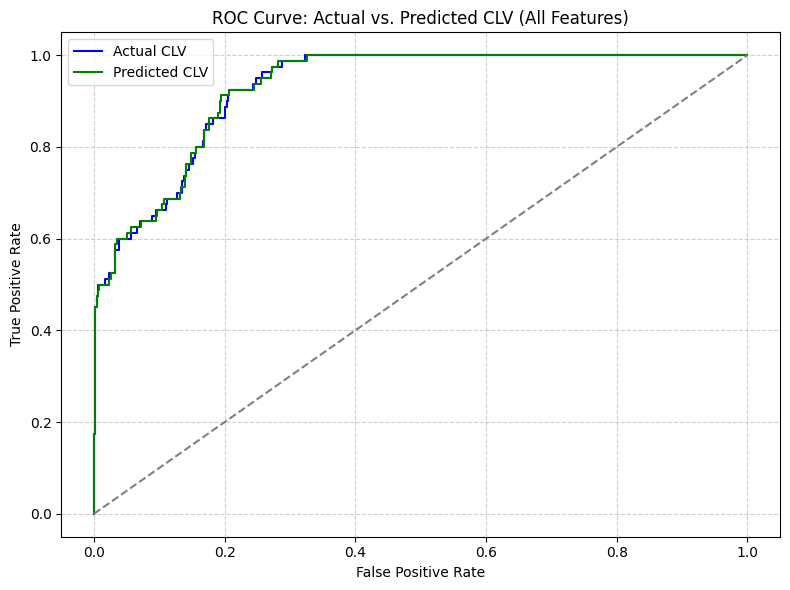

In [1219]:
fpr_a, tpr_a, _ = roc_curve(y_test_a, y_prob_a)
fpr_b, tpr_b, _ = roc_curve(y_test_b, y_prob_b)

plt.figure(figsize=(8, 6))
plt.plot(fpr_a, tpr_a, label="Actual CLV", color="blue")
plt.plot(fpr_b, tpr_b, label="Predicted CLV", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Actual vs. Predicted CLV (All Features)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#### **actual CLV** vs **predicted CLV**


| Metric       | Using Actual CLV | Using Predicted CLV |
|--------------|------------------|----------------------|
| Accuracy     | 84%              | 84%              |
| Recall (Class 1 - Churn) | 76%         | 79%            |
| F1-Score (Class 1) | 0.57         | 0.59              |
| AUC Score    | 0.9287           | 0.9292            |


- Both models demonstrate strong performance in predicting churn, with very similar overall accuracy and AUC.
- Predicted CLV performs slightly better on below metrics:
  - Higher recall (more true churners detected)
  - Slightly better F1-score
  - Marginally improved AUC
- This suggests that the regression-predicted CLV can effectively substitute actual CLV in scenarios where true CLV isn’t directly available.

#### **Cross-Validation with SMOTE**

In [1220]:
def evaluate_logistic_pipeline_cv(X, y, num_f, cat_f, clv_label="Actual CLV", k=5):
    # Preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_f)
    ])

    # Full pipeline with SMOTE
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(max_iter=1000))
    ])

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Evaluate with multiple metrics
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=skf,
        scoring=["roc_auc", "recall", "f1"],
        return_train_score=False
    )

    # Print fold results
    for i in range(k):
        print(f"\n Fold {i+1} | AUC: {scores['test_roc_auc'][i]:.4f} | Recall: {scores['test_recall'][i]:.4f} | F1: {scores['test_f1'][i]:.4f}")

    # Print average scores
    print(f"\n {k}-Fold Cross-Validation Results ({clv_label}):")
    print(f"Average AUC:    {np.mean(scores['test_roc_auc']):.4f}")
    print(f"Average Recall: {np.mean(scores['test_recall']):.4f}")
    print(f"Average F1:     {np.mean(scores['test_f1']):.4f}")
    return pipeline

##### Opting for Actual CLV Over Predicted CLV Despite Minor Improvements in Predictions

In [1221]:
cv_pipeline_a = evaluate_logistic_pipeline_cv(X_a, y, num_f=numeric_features_a, cat_f=categorical_features, clv_label="Using Actual CLV")
cv_pipeline_a


 Fold 1 | AUC: 0.9282 | Recall: 0.8625 | F1: 0.6188

 Fold 2 | AUC: 0.9193 | Recall: 0.8125 | F1: 0.5752

 Fold 3 | AUC: 0.9257 | Recall: 0.8625 | F1: 0.5948

 Fold 4 | AUC: 0.9480 | Recall: 0.8889 | F1: 0.6234

 Fold 5 | AUC: 0.9416 | Recall: 0.8642 | F1: 0.6306

 5-Fold Cross-Validation Results (Using Actual CLV):
Average AUC:    0.9326
Average Recall: 0.8581
Average F1:     0.6086


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['call_failure',
                                                   'subscription_length',
                                                   'complains',
                                                   'seconds_of_use',
                                                   'frequency_of_SMS',
                                                   'distinct_called_numbers',
                                                   'charge_amount',
                                                   'status_active',
                                                   'customer_value']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['tariff_plan',
                                                   'age_group'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

#### **Interpret Models Using Co-efficient and Odds ratio**

In [1185]:
def interpret_logistic_model(coef_df, title="Feature Impact on Churn"):
    coef_df = coef_df.sort_values("Coefficient")

    # Compute odds ratio
    coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])

    # Bar colors
    color_palette = coef_df["Coefficient"].apply(lambda x: "#D62728" if x > 0 else "#2CA02C")

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=coef_df["Coefficient"],
        y=coef_df["Feature"],
        orient="h"
    )

    # Color bars
    for bar, color in zip(ax.patches, color_palette):
        bar.set_facecolor(color)
        bar.set_edgecolor("black")

    # Annotate with odds ratio
    for i, (_, row) in enumerate(coef_df.iterrows()):
        coef = row["Coefficient"]
        odds = row["Odds Ratio"]
        x_pos = coef + 0.1 if coef > 0 else coef - 0.1
        ha = 'left' if coef > 0 else 'right'
        ax.text(x_pos, i, f"OR: {odds:.2f}", va='center', ha=ha, fontsize=9, color='black')

    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.title(title, fontsize=13)
    plt.xlabel("Coefficient (Effect on Churn)")
    plt.ylabel("Feature")
    plt.grid(axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()



##### Base Model Interpretation with Actual CLV

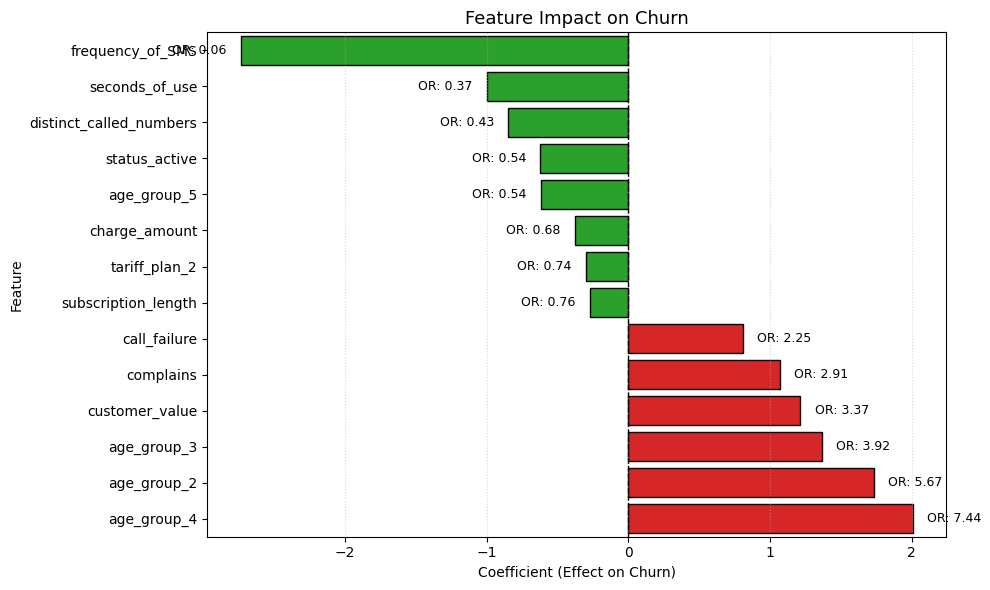

In [1222]:
interpret_logistic_model(coef_df_a)

**Features increasing churn risk (red bars):**

- Age group 4 has the highest impact (OR: 7.90), making customers in this group nearly 8 times more likely to churn
- Age group 2 (OR: 6.18) and Age group 3 (OR: 4.62) also significantly increase churn risk
- Customers who complain (OR: 2.99), have high customer value (OR: 2.37), and experience call failures (OR: 2.13) are more likely to churn

**Features decreasing churn risk (green bars):**

- Higher frequency of SMS (OR: 0.08) strongly reduces churn risk
- More seconds of use (OR: 0.34), age group 5 (OR: 0.36), and higher distinct called numbers (OR: 0.43) all decrease churn probability
- Active status (OR: 0.61), charge amount (OR: 0.72), and tariff plan 2 (OR: 0.96) have moderate protective effects against churn

##### Interpret Cross-Validated Model with Actual CLV

In [1223]:
# Cross validated pipeline
final_pipeline = cv_pipeline_a.fit(X_a, y)

# Extract components
preprocessor = final_pipeline.named_steps["preprocessor"]
classifier = final_pipeline.named_steps["classifier"]
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = list(numeric_features_a) + list(cat_features)

coef_df_cv_a = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": classifier.coef_[0],
    "Odds Ratio": np.exp(classifier.coef_[0])
}).sort_values(by="Coefficient", key=abs, ascending=False)

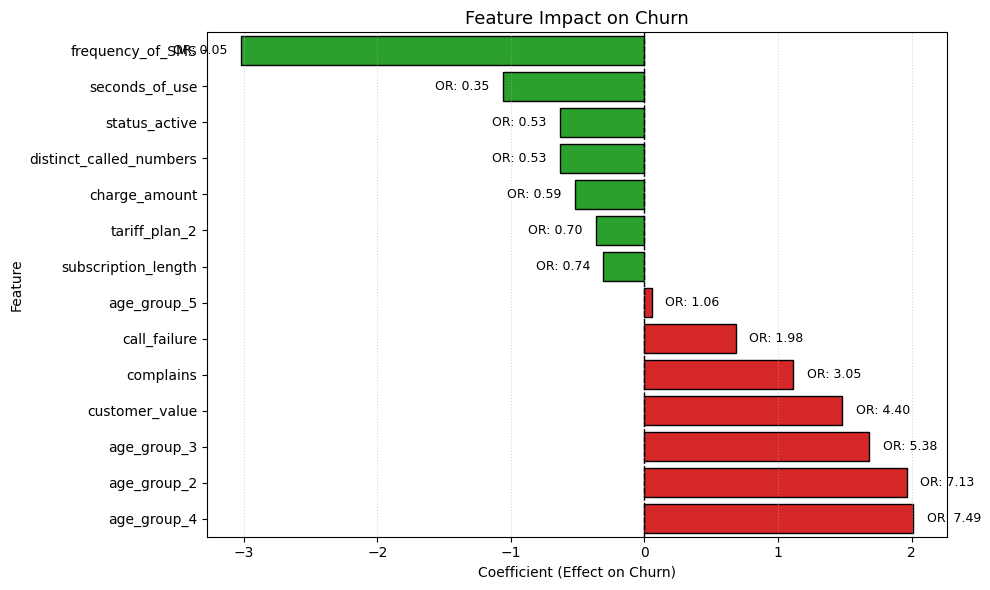

In [1224]:
interpret_logistic_model(coef_df_cv_a)

#### **Assessing the Role of `customer_value (CLV)` in Churn Prediction**

Since `customer_value` has a positive coefficient, it implies that a higher CLV drives a higher churn probability, which contradicts business sense because high-value customers are expected to stay. We will assess the impact of `customer_value` on predicting churn.

##### **1. Logistic Regression with Only customer_value**

In [1225]:
numeric_features_only_clv = ["customer_value"]

X_only_clv = X[numeric_features_only_clv + []]
X_only_clv.head()

,customer_value
0,197.640
1,46.035
2,1536.520
3,240.020
4,145.805


In [1226]:
evaluate_logistic_pipeline_cv(
    X_only_clv,
    y,
    num_f=numeric_features_only_clv,
    cat_f=[],
    clv_label="Role of customer_value"
)


 Fold 1 | AUC: 0.7616 | Recall: 0.8250 | F1: 0.3697

 Fold 2 | AUC: 0.7626 | Recall: 0.8500 | F1: 0.3646

 Fold 3 | AUC: 0.7444 | Recall: 0.7875 | F1: 0.3481

 Fold 4 | AUC: 0.7896 | Recall: 0.8765 | F1: 0.3890

 Fold 5 | AUC: 0.7997 | Recall: 0.9383 | F1: 0.4108

 5-Fold Cross-Validation Results (Role of customer_value):
Average AUC:    0.7716
Average Recall: 0.8555
Average F1:     0.3765


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_value']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

#### **2. Logistic Regression with All Features Except `customer_value`**


In [1227]:
X_excl_clv = X[numeric_features + categorical_features]

X_excl_clv.head()

,call_failure,subscription_length,complains,seconds_of_use,frequency_of_SMS,distinct_called_numbers,charge_amount,status_active,tariff_plan,age_group
0,8,38,0,4370,5,17,0,1,1,3
1,0,39,0,318,7,4,0,0,1,2
2,10,37,0,2453,359,24,0,1,1,3
3,10,38,0,4198,1,35,0,1,1,1
4,3,38,0,2393,2,33,0,1,1,1


In [1228]:
evaluate_logistic_pipeline_cv(
    X_excl_clv,
    y,
    num_f=numeric_features,
    cat_f=categorical_features,
    clv_label="Role of all features except customer_value"
)



 Fold 1 | AUC: 0.9273 | Recall: 0.8625 | F1: 0.6188

 Fold 2 | AUC: 0.9182 | Recall: 0.8125 | F1: 0.5752

 Fold 3 | AUC: 0.9251 | Recall: 0.8625 | F1: 0.5923

 Fold 4 | AUC: 0.9475 | Recall: 0.8889 | F1: 0.6234

 Fold 5 | AUC: 0.9412 | Recall: 0.8642 | F1: 0.6306

 5-Fold Cross-Validation Results (Role of all features except customer_value):
Average AUC:    0.9319
Average Recall: 0.8581
Average F1:     0.6081


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['call_failure',
                                                   'subscription_length',
                                                   'complains',
                                                   'seconds_of_use',
                                                   'frequency_of_SMS',
                                                   'distinct_called_numbers',
                                                   'charge_amount',
                                                   'status_active']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['tariff_plan',
                                                   'age_group'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

##### **Check Multi-Colinearity as `customer_value` is predicted using other features in regression**

##### Correlations with customer_value

In [1229]:
# Correlations with customer_value
corr_matrix = df[numeric_features + ["customer_value"]].corr()
corr_with_clv = corr_matrix["customer_value"].sort_values(ascending=False)
print(corr_with_clv)

customer_value             1.000000
frequency_of_SMS           0.922416
status_active              0.392245
seconds_of_use             0.389987
distinct_called_numbers    0.246604
charge_amount              0.147241
subscription_length        0.111394
call_failure               0.082509
complains                 -0.134901
Name: customer_value, dtype: float64


- frequency_of_SMS is highly collinear with customer_value (0.92 is very strong).

##### VIF Analysis

In [1230]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [1231]:
# Subset with numeric features only
X_numeric = df[numeric_features + ["customer_value"]]
X_vif = add_constant(X_numeric)

vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                   Feature        VIF
9           customer_value  25.195981
0                    const  23.419761
5         frequency_of_SMS  21.443139
4           seconds_of_use   5.128680
1             call_failure   2.053335
7            charge_amount   1.952047
6  distinct_called_numbers   1.936767
8            status_active   1.749501
3                complains   1.152563
2      subscription_length   1.120639


- customer_value and frequency_of_SMS are strongly collinear and are likely encoding the same behavior.

In [1232]:
# Remove customer_value keep frequency_of_SMS
X_numeric = df[numeric_features]
X_vif = add_constant(X_numeric)

vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                   Feature        VIF
0                    const  23.321114
4           seconds_of_use   2.136984
1             call_failure   2.049126
6  distinct_called_numbers   1.936752
7            charge_amount   1.771523
8            status_active   1.737240
3                complains   1.152040
2      subscription_length   1.119890
5         frequency_of_SMS   1.117195


In [1234]:
# Drop frequency_of_SMS and keep customer_value
X_numeric = df[numeric_features + ["customer_value"]].drop(columns="frequency_of_SMS")
X_vif = add_constant(X_numeric)

vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

                   Feature        VIF
0                    const  23.365451
4           seconds_of_use   2.264738
1             call_failure   2.046599
5  distinct_called_numbers   1.936566
6            charge_amount   1.775514
7            status_active   1.748631
8           customer_value   1.312719
3                complains   1.151962
2      subscription_length   1.120557


- VIF analysis suggests multicollinearity is resolved by either keeping `customer_value` or `frequency_of_SMS`.

#### **Logistic Regression with All Features removing `frequency_of_SMS` and keeping `customer_value`**

In [1235]:
numeric_features.remove("frequency_of_SMS")
numeric_features.append("customer_value")
numeric_features

['call_failure',
 'subscription_length',
 'complains',
 'seconds_of_use',
 'distinct_called_numbers',
 'charge_amount',
 'status_active',
 'customer_value']

In [1236]:

X_excl_fsms = X[numeric_features + categorical_features]

X_excl_fsms.head()

,call_failure,subscription_length,complains,seconds_of_use,distinct_called_numbers,charge_amount,status_active,customer_value,tariff_plan,age_group
0,8,38,0,4370,17,0,1,197.640,1,3
1,0,39,0,318,4,0,0,46.035,1,2
2,10,37,0,2453,24,0,1,1536.520,1,3
3,10,38,0,4198,35,0,1,240.020,1,1
4,3,38,0,2393,33,0,1,145.805,1,1


In [1237]:
cv_pipeline_with_clv = evaluate_logistic_pipeline_cv(
    X_excl_fsms,
    y,
    num_f=numeric_features,
    cat_f=categorical_features,
    clv_label="Role of all features except frequency_of_SMS"
)


 Fold 1 | AUC: 0.9260 | Recall: 0.8625 | F1: 0.6161

 Fold 2 | AUC: 0.9164 | Recall: 0.8250 | F1: 0.5841

 Fold 3 | AUC: 0.9232 | Recall: 0.8750 | F1: 0.5907

 Fold 4 | AUC: 0.9483 | Recall: 0.8889 | F1: 0.6234

 Fold 5 | AUC: 0.9411 | Recall: 0.8642 | F1: 0.6250

 5-Fold Cross-Validation Results (Role of all features except frequency_of_SMS):
Average AUC:    0.9310
Average Recall: 0.8631
Average F1:     0.6078


#### **Model Performance Comparison**

We analyzed the impact of customer_value on churn prediction performance across three scenarios:

| Feature Set                          | AUC     | Recall  | F1     |
|--------------------------------------|---------|---------|--------|
| Only customer_value                      | 0.7716  | 0.8555  | 0.3765 |
| All features except customer_value       | 0.9319 | 0.8581 | 0.6081 |
| All features except frequency_of_SMS     | 0.9310  | 0.8631  | 0.6078 |

- CLV-only model achieves high recall, confirming that customer_value does contain strong signal related to churn. However, it performs poorly on F1 score due to many false positives, indicating lack of precision.
- Both full-feature models (with CLV or with frequency_of_SMS) perform equally well, suggesting these features encode similar behavior.
- The model without frequency_of_SMS (keeping CLV) is preferred for interpretability and business alignment.

#### **Conclusion:**


- customer_value (CLV) is confirmed as a valid predictor of churn when combined with other features.
- Multicollinearity was addressed by removing frequency_of_SMS from the dataset.
- Similar performance observed between models using all features and those excluding frequency_of_SMS.
- Recommendation to retain customer_value in the final model while eliminating frequency_of_SMS for better interpretability.
- Decision aligns with the goal of ensuring robust predictive performance and providing actionable insights for business stakeholders.

#### **Inspect & Visualize Coefficients with Final Model**

In [1238]:
X_final = X.drop(columns=['frequency_of_SMS', 'predicted_clv'])
X_final.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,distinct_called_numbers,age_group,tariff_plan,customer_value,status_active
0,8,0,38,0,4370,17,3,1,197.640,1
1,0,0,39,0,318,4,2,1,46.035,0
2,10,0,37,0,2453,24,3,1,1536.520,1
3,10,0,38,0,4198,35,1,1,240.020,1
4,3,0,38,0,2393,33,1,1,145.805,1


In [1239]:
final_model = cv_pipeline_with_clv.fit(X_final, y)

# Extract components
preprocessor = final_model.named_steps["preprocessor"]
classifier = final_model.named_steps["classifier"]
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)

coef_df_final = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": classifier.coef_[0],
    "Odds Ratio": np.exp(classifier.coef_[0])
}).sort_values(by="Coefficient", key=abs, ascending=False)

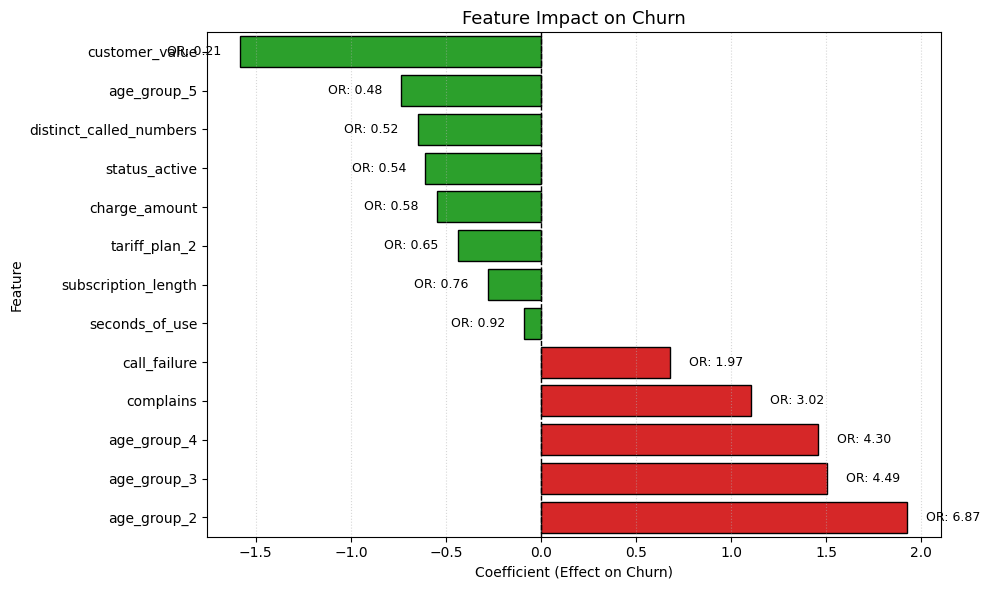

In [1240]:
interpret_logistic_model(coef_df_final)

**Coefficient Comparison Summary**



| Scenario | Key Observations |
|----------|------------------|
| With frequency_of_SMS and CLV | frequency_of_SMS dominates with a very large negative coefficient (OR ≈ 0.06), and CLV has a positive coefficient (OR ≈ 3.11) |
| Without frequency_of_SMS (Final Model) | CLV becomes the strongest driver of churn risk (largest negative coefficient), suggesting it's absorbing the behavioral signal |


- When both customer_value and frequency_of_SMS were included, frequency_of_SMS dominated the model with a very strong negative coefficient (OR ≈ 0.06).
- This resulted in a positive coefficient for CLV (OR > 3), contradicting intuition that high CLV customers should be less likely to churn.
- When we removed frequency_of_SMS, the coefficient of CLV shifted to negative (OR ≈ 0.18), making the interpretation more aligned with business logic.
- The remaining feature effects remained consistent across both models, indicating that removing frequency_of_SMS did not disrupt model stability.

Final model includes customer_value and excludes frequency_of_SMS, balancing performance and interpretability.